In [3]:
import datetime
import json
import os
import sys
import pandas as pd
import numpy as np
import sys
import tensorflow as tf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import keras


with open('../data/cluster_limits.json') as json_data:
    dict_classe = json.loads(json_data.read())


dataset_file_path = "../data/dados_2014-2022.csv"
dataset = pd.read_csv(dataset_file_path, index_col=0)

dataset_original = dataset.copy()
folder_figures = "../plots/"

columns_Y = ["UpwardUsedSecondaryReserveEnergy", "DownwardUsedSecondaryReserveEnergy"]
columns_Y = ["UpwardUsedSecondaryReserveEnergy"]
alloc_column = ["SecondaryReserveAllocationAUpward"]

y_columns = columns_Y
datetime_col = "datetime"


d = pd.to_datetime(dataset[datetime_col], format="mixed", utc=True)
columns_X = dataset.columns[~dataset.columns.isin(columns_Y)]

mean = [t for f,t in dataset[columns_Y].copy().replace(0, np.nan).mean().items()]


dataset["hour"] = [f.hour for f in d]
dataset["day"] = [f.day for f in d]
dataset["month"] = [f.month for f in d]
dataset["year"] = [f.year for f in d]
dataset["day_of_year"] = [f.timetuple().tm_yday for f in d]
dataset["day_of_week"] = [f.timetuple().tm_wday for f in d]
dataset["week_of_year"] = [f.weekofyear for f in d]



time_cols = ["hour", "day", "month", "year", "day_of_year", "day_of_week", "week_of_year"]
# Make the y the 1st column
dataset = dataset[y_columns+[col for col in dataset.columns if col not in y_columns]]

# make the time columns the last
dataset = dataset[[col for col in dataset.columns if col not in time_cols]+time_cols]


df = dataset.copy()
df.drop("datetime", axis=1, inplace=True)
# Sort DataFrame by DateTime index
df.sort_index(inplace=True)

# Perform imputation
imputer = IterativeImputer(max_iter=10, random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert the result back to a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns, index=df.index)
df_imputed["datetime"] = dataset["datetime"]
dataset = df_imputed.copy()
df_imputed = None

2023-09-20 10:12:19.607053: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 10:12:19.906071: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 10:12:19.908766: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 10:12:23.065676: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# On this Validation we will only use the  data from 2022
mask_2022 = dataset["year"]==2022


test_dataset = dataset[mask_2022].copy().iloc[:8712]

mask_last_week_2021 = dataset["year"]==2021

week_hours_plus_day = (24*7)

mmm = mask_last_week_2021[mask_last_week_2021].iloc[-week_hours_plus_day:]

mmme = mmm & mask_last_week_2021

mask_data = mmme | mask_2022

dataset = dataset[mask_data]



<Axes: >

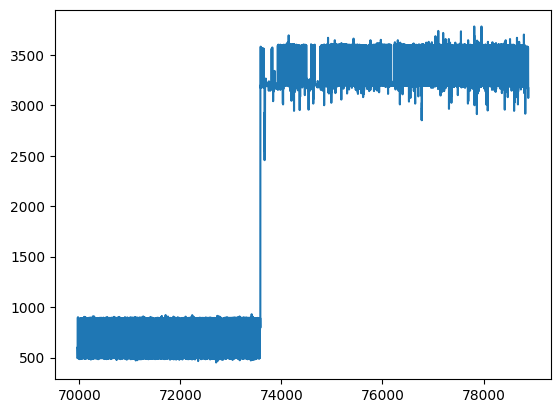

In [5]:
dataset["SecondaryReserveAllocationAUpward"].plot()

In [6]:
import pathlib
path_to_trained_models = "../models_trained/"
models_structures = os.listdir(path_to_trained_models)
os.listdir(os.path.abspath(path_to_trained_models))


['one_model_per_hour_with_classes', 'single_models', 'models_with_classes']

In [7]:
models_structures

['one_model_per_hour_with_classes', 'single_models', 'models_with_classes']

In [8]:
results_df = test_dataset[columns_Y + ["SecondaryReserveAllocationAUpward", "datetime"]].copy()
results_df.reset_index(drop=True, inplace=True)

results_df_label = test_dataset[columns_Y + ["SecondaryReserveAllocationAUpward", "datetime"]].copy()
results_df_label.reset_index(drop=True, inplace=True)

In [18]:
import glob
import importlib
import keras
import tensorflow_decision_forests as tfdf
save_results_folder = "../model_results_2022"





for struct in models_structures:
    #if not "one_model_per_hour_with_classes" in struct:
    #    continue
    strutc_path =  pathlib.Path(os.path.join(pathlib.Path(path_to_trained_models).resolve(), struct))
    list_models =  strutc_path.glob(f'**/*.keras')
    list_models = [f for f in list_models]
    generator_script =  strutc_path.glob(f'**/*.py')
    generator_script = [f for f in generator_script]
    script = generator_script[0]
    spec = importlib.util.spec_from_file_location("module.name", script)
    module = importlib.util.module_from_spec(spec)

    sys.path.insert(0, os.path.dirname(script)) # Add the script's directory to the system path
    sys.modules[spec.name] = module 
    spec.loader.exec_module(module)

    get_dataset = getattr(module, "get_dataset", None)  # Get the "get_dataset" function from the module
    prepare_for_data = getattr(module, "prepare_for_data", None)  # Get the "get_dataset" function from the module
    prepare_for_model = getattr(module, "prepare_for_model", None)  # Get the "get_dataset" function from the module
    prediction_from_model = getattr(module, "prediction_from_model", None)
    merge_predictions = getattr(module, "merge_predictions", None)
    
    if get_dataset is None:
        print(f"Error: Function 'get_dataset' not found in module {module.__name__}")
        continue
    # Here you can use the get_dataset function. 
    # Don't forget to remove the directory from sys.path if you don't need it anymore.
    sys.path.remove(os.path.dirname(script))


    results_df_label_struct = pd.DataFrame()
    results_df_struct = pd.DataFrame()

    

    for model_path in list_models:

        model_keras = keras.models.load_model(model_path, safe_mode=False,
                                    compile=False)

        
        model_name = os.path.basename(os.path.dirname(os.path.dirname(model_path)))
        model_name = f"{model_name}_{os.path.basename(os.path.dirname(model_path))}"
        model_name = f"{model_name}_{os.path.basename(model_path)}"

        print(model_name)
        if isinstance(model_keras, tfdf.keras.RandomForestModel):
            model_input_shape = None
            model_output_shape = None
            continue

        else:
            model_input_shape = model_keras.input_shape
            model_output_shape = model_keras.output_shape

        extra_args = {}
        data_metadata = prepare_for_data(model_input_shape, model_output_shape)

        X_timeseries = data_metadata["X_timeseries"]
        Y_timeseries = data_metadata["Y_timeseries"]
        frac = 1
        train_features_folga = 24
        skiping_step=24
        if "Y_label_dim" in data_metadata:
            y_val = columns_Y[0]
            num_classes = data_metadata["Y_classes"]-1
            key_g = f"{y_val}_{num_classes}"
            dict_classe[key_g][0]=[0]
            extra_args["classes_dict"]=dict_classe[key_g]
        data_to_go = dataset.copy()
        get_dataset_output = get_dataset(
                data_to_go,
                drop_cols=datetime_col,
                y_columns=columns_Y,
                time_moving_window_size_X=X_timeseries,
                time_moving_window_size_Y=Y_timeseries,
                frac=frac,
                keep_y_on_x=True,  # after some intial anlysis keeping the band of the day before helped the models
                train_features_folga=train_features_folga,        
                skiping_step=skiping_step,
                time_cols=time_cols,
                **extra_args,
            )

        X, Y = prepare_for_model(get_dataset_output, model_input_shape, model_output_shape)
        break
        predictions = model_keras.predict(X)
        pred_dict = prediction_from_model(predictions, model_output_shape, model_name, data_metadata)

        
        for key in pred_dict:
            if "label" in key:
                results_df_label_struct[key]=pred_dict[key]
            else:
                results_df_struct[key]=pred_dict[key]
                    
    print("----------------------------------------------")
    if merge_predictions is not None:
        print(len(results_df_struct))
        results_df_label_struct = merge_predictions(results_df_label_struct)
        results_df_struct = merge_predictions(results_df_struct)
    
    results_df = pd.concat([results_df, results_df_struct.iloc[:len(results_df)]], axis=1)
    results_df_label = pd.concat([results_df_label, results_df_label_struct.iloc[:len(results_df_label)]], axis=1)

#results_df.dropna(axis=1, inplace=True)
    

Tail_cluster_study_results_6_keras_random_forest_0_model_keras_0_1_2_3_4.keras
Tail_cluster_study_results_6_keras_random_forest_0_model_keras_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18.keras
Tail_cluster_study_results_6_keras_random_forest_0_model_keras_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20.keras
Tail_cluster_study_results_6_keras_random_forest_0_model_keras_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21.keras
Tail_cluster_study_results_6_keras_random_forest_0_model_keras_0_1_2_3_4_5_6_7.keras
Tail_cluster_study_results_6_keras_random_forest_0_model_keras_0.keras
Tail_cluster_study_results_6_keras_random_forest_0_model_keras_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14.keras
Tail_cluster_study_results_6_keras_random_forest_0_model_keras_0_1_2_3_4_5_6_7_8.keras
Tail_cluster_study_results_6_keras_random_forest_0_model_keras_0_1_2_3_4_5_6_7_8_9.keras
Tail_cluster_study_results_6_keras_random_forest_0_model_keras_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15.keras
Tail_cluster_st

<Axes: >

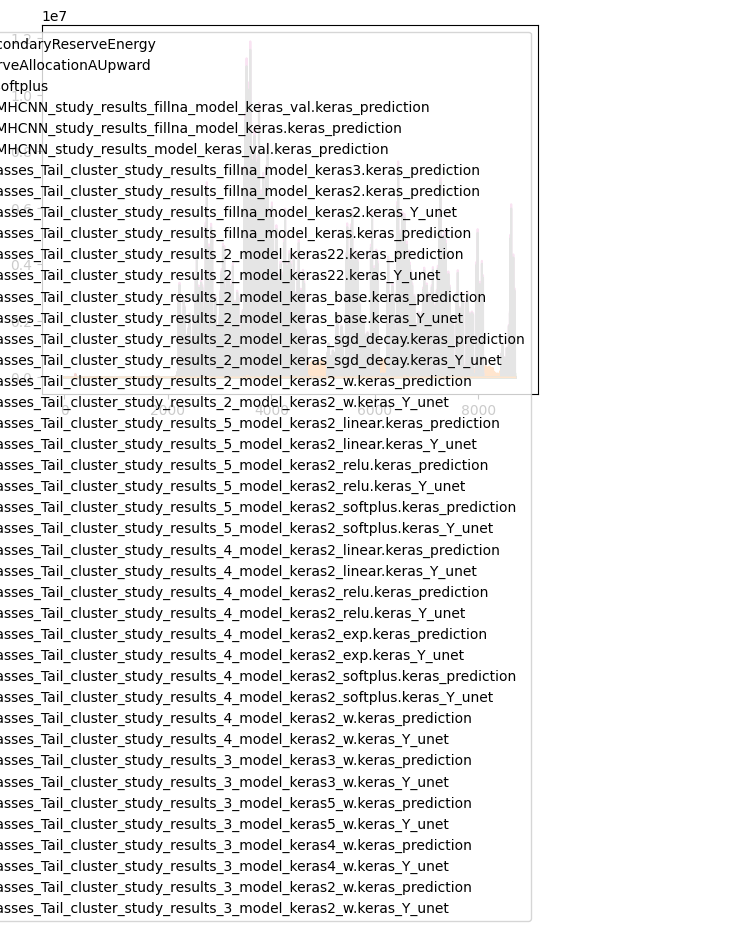

In [10]:
results_df.plot()

In [11]:
results_df

,UpwardUsedSecondaryReserveEnergy,SecondaryReserveAllocationAUpward,datetime,model_keras2_softplus,single_models_MHCNN_study_results_fillna_model_keras_val.keras_prediction,single_models_MHCNN_study_results_fillna_model_keras.keras_prediction,single_models_MHCNN_study_results_model_keras_val.keras_prediction,models_with_classes_Tail_cluster_study_results_fillna_model_keras3.keras_prediction,models_with_classes_Tail_cluster_study_results_fillna_model_keras2.keras_prediction,models_with_classes_Tail_cluster_study_results_fillna_model_keras2.keras_Y_unet,...,models_with_classes_Tail_cluster_study_results_4_model_keras2_w.keras_prediction,models_with_classes_Tail_cluster_study_results_4_model_keras2_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras3_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras3_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras5_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras5_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras4_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras4_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras2_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras2_w.keras_Y_unet
0,755.0,495.0,2022-01-01 01:00:00+01:00,837.026733,149.500900,173.657043,148.370926,2.516438,161.111572,158.666809,...,199.490891,210.059006,0.0,5188.177734,14.303938,1439.424072,0.000000,0.000000,0.0,1121.764893
1,50.1,495.0,2022-01-01 02:00:00+01:00,48.659409,179.445114,192.327438,168.717407,2.503977,163.892227,161.413193,...,242.141159,244.631287,0.0,10164.407227,0.072844,0.000000,69.100975,1273.396240,0.0,0.000000
2,164.6,493.0,2022-01-01 03:00:00+01:00,0.000000,184.278519,205.564682,166.052887,2.506404,169.783279,167.220688,...,252.372131,256.844818,0.0,6093.156250,6.058074,611.576721,0.000000,0.000000,0.0,665.186768
3,84.6,494.0,2022-01-01 04:00:00+01:00,0.213296,141.285721,178.830368,169.531754,2.511318,250.452881,246.833221,...,249.641312,252.632904,0.0,5459.995117,24.537281,2466.813232,9.744311,180.591400,0.0,106.913818
4,242.5,496.0,2022-01-01 05:00:00+01:00,0.144550,148.031433,247.274551,150.290909,2.515424,203.868683,200.869156,...,215.579880,216.704315,0.0,3709.840332,0.072844,0.000000,96.147537,1771.345215,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8707,772.2,3208.0,2022-12-29 21:00:00+01:00,1.565706,165.293198,128.755661,152.266113,2.472012,191.974579,189.130920,...,244.630676,247.908554,0.0,10145.607422,6.209421,626.770630,0.000000,0.000000,0.0,451.136719
8708,217.4,3184.0,2022-12-29 22:00:00+01:00,2.924263,156.826645,161.250092,168.713089,2.488521,263.628723,259.828033,...,270.858704,275.336761,0.0,144.894775,2.695199,273.956360,0.000000,0.000000,0.0,0.000000
8709,69.9,3184.0,2022-12-29 23:00:00+01:00,69.297417,194.013367,190.518066,192.440536,2.448747,236.688110,233.252213,...,280.509613,285.819733,0.0,5557.790039,1.193107,123.152138,128.628860,2369.354248,0.0,0.000000
8710,34.6,3180.0,2022-12-30 00:00:00+01:00,156117.937500,246.732391,242.452042,196.983139,2.437079,198.046692,195.092728,...,286.380615,291.935272,0.0,5258.094727,0.072844,0.000000,0.000000,0.000000,0.0,1550.263306


In [12]:
true_test_col = "UpwardUsedSecondaryReserveEnergy"
alloc_test_col = "SecondaryReserveAllocationAUpward"

pred_cols = [f for f in results_df.columns if f not in [true_test_col, alloc_test_col, "datetime"]]

erro_dict_true = {}
erro_dict_alloc = {}
erro_dict_alloc_comp = {}

for col in pred_cols:
    true_erro = results_df[true_test_col] - results_df[col]
    alloc_erro = np.where(results_df[col] >= results_df[true_test_col], 0, results_df[true_test_col]-results_df[col])
    erro_dict_alloc[col]=alloc_erro

error_alloc_df = pd.DataFrame(erro_dict_alloc)
error_alloc_df["baseline_error"] = np.where(results_df[alloc_test_col] >= results_df[true_test_col], 0, results_df[true_test_col]-results_df[alloc_test_col])

In [13]:
error_alloc_df

,model_keras2_softplus,single_models_MHCNN_study_results_fillna_model_keras_val.keras_prediction,single_models_MHCNN_study_results_fillna_model_keras.keras_prediction,single_models_MHCNN_study_results_model_keras_val.keras_prediction,models_with_classes_Tail_cluster_study_results_fillna_model_keras3.keras_prediction,models_with_classes_Tail_cluster_study_results_fillna_model_keras2.keras_prediction,models_with_classes_Tail_cluster_study_results_fillna_model_keras2.keras_Y_unet,models_with_classes_Tail_cluster_study_results_fillna_model_keras.keras_prediction,models_with_classes_Tail_cluster_study_results_2_model_keras22.keras_prediction,models_with_classes_Tail_cluster_study_results_2_model_keras22.keras_Y_unet,...,models_with_classes_Tail_cluster_study_results_4_model_keras2_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras3_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras3_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras5_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras5_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras4_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras4_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras2_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras2_w.keras_Y_unet,baseline_error
0,0.000000,605.499100,581.342957,606.629074,752.483562,593.888428,596.333191,589.410263,733.119656,712.462563,...,544.940994,755.0,0.000000,740.696062,0.00000,755.000000,755.0,755.0,0.000000,260.0
1,1.440591,0.000000,0.000000,0.000000,47.596023,0.000000,0.000000,0.000000,8.295541,0.000000,...,0.000000,50.1,0.000000,50.027156,50.10000,0.000000,0.0,50.1,50.100000,0.0
2,164.600000,0.000000,0.000000,0.000000,162.093596,0.000000,0.000000,29.293954,95.282632,28.585306,...,0.000000,164.6,0.000000,158.541926,0.00000,164.600000,164.6,164.6,0.000000,0.0
3,84.386704,0.000000,0.000000,0.000000,82.088682,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,84.6,0.000000,60.062719,0.00000,74.855689,0.0,84.6,0.000000,0.0
4,242.355450,94.468567,0.000000,92.209091,239.984576,38.631317,41.630844,27.267365,31.261246,0.000000,...,25.795685,242.5,0.000000,242.427156,242.50000,146.352463,0.0,242.5,242.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8707,770.634294,606.906802,643.444339,619.933887,769.727988,580.225421,583.069080,578.843311,0.000000,0.000000,...,524.291446,772.2,0.000000,765.990579,145.42937,772.200000,772.2,772.2,321.063281,0.0
8708,214.475737,60.573355,56.149908,48.686911,214.911479,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,217.4,72.505225,214.704801,0.00000,217.400000,217.4,217.4,217.400000,0.0
8709,0.602583,0.000000,0.000000,0.000000,67.451253,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,69.9,0.000000,68.706893,0.00000,0.000000,0.0,69.9,69.900000,0.0
8710,0.000000,0.000000,0.000000,0.000000,32.162921,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,34.6,0.000000,34.527156,34.60000,34.600000,34.6,34.6,0.000000,0.0


In [14]:
error_alloc_df

,model_keras2_softplus,single_models_MHCNN_study_results_fillna_model_keras_val.keras_prediction,single_models_MHCNN_study_results_fillna_model_keras.keras_prediction,single_models_MHCNN_study_results_model_keras_val.keras_prediction,models_with_classes_Tail_cluster_study_results_fillna_model_keras3.keras_prediction,models_with_classes_Tail_cluster_study_results_fillna_model_keras2.keras_prediction,models_with_classes_Tail_cluster_study_results_fillna_model_keras2.keras_Y_unet,models_with_classes_Tail_cluster_study_results_fillna_model_keras.keras_prediction,models_with_classes_Tail_cluster_study_results_2_model_keras22.keras_prediction,models_with_classes_Tail_cluster_study_results_2_model_keras22.keras_Y_unet,...,models_with_classes_Tail_cluster_study_results_4_model_keras2_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras3_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras3_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras5_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras5_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras4_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras4_w.keras_Y_unet,models_with_classes_Tail_cluster_study_results_3_model_keras2_w.keras_prediction,models_with_classes_Tail_cluster_study_results_3_model_keras2_w.keras_Y_unet,baseline_error
0,0.000000,605.499100,581.342957,606.629074,752.483562,593.888428,596.333191,589.410263,733.119656,712.462563,...,544.940994,755.0,0.000000,740.696062,0.00000,755.000000,755.0,755.0,0.000000,260.0
1,1.440591,0.000000,0.000000,0.000000,47.596023,0.000000,0.000000,0.000000,8.295541,0.000000,...,0.000000,50.1,0.000000,50.027156,50.10000,0.000000,0.0,50.1,50.100000,0.0
2,164.600000,0.000000,0.000000,0.000000,162.093596,0.000000,0.000000,29.293954,95.282632,28.585306,...,0.000000,164.6,0.000000,158.541926,0.00000,164.600000,164.6,164.6,0.000000,0.0
3,84.386704,0.000000,0.000000,0.000000,82.088682,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,84.6,0.000000,60.062719,0.00000,74.855689,0.0,84.6,0.000000,0.0
4,242.355450,94.468567,0.000000,92.209091,239.984576,38.631317,41.630844,27.267365,31.261246,0.000000,...,25.795685,242.5,0.000000,242.427156,242.50000,146.352463,0.0,242.5,242.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8707,770.634294,606.906802,643.444339,619.933887,769.727988,580.225421,583.069080,578.843311,0.000000,0.000000,...,524.291446,772.2,0.000000,765.990579,145.42937,772.200000,772.2,772.2,321.063281,0.0
8708,214.475737,60.573355,56.149908,48.686911,214.911479,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,217.4,72.505225,214.704801,0.00000,217.400000,217.4,217.4,217.400000,0.0
8709,0.602583,0.000000,0.000000,0.000000,67.451253,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,69.9,0.000000,68.706893,0.00000,0.000000,0.0,69.9,69.900000,0.0
8710,0.000000,0.000000,0.000000,0.000000,32.162921,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,34.6,0.000000,34.527156,34.60000,34.600000,34.6,34.6,0.000000,0.0


<Axes: >

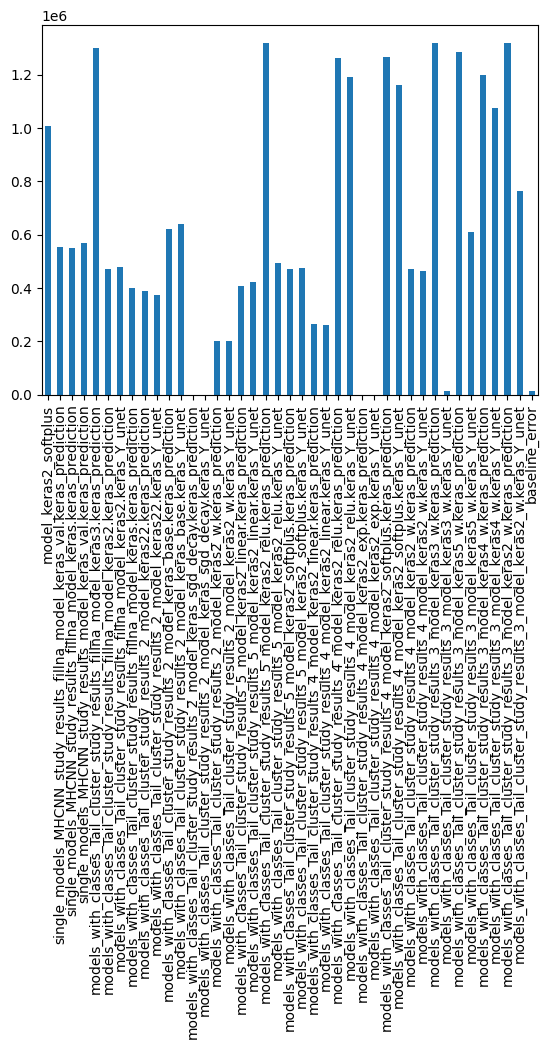

In [15]:
error_alloc_df.sum().plot.bar()

In [16]:
baseline_sum = error_alloc_df['baseline_error'].sum()
better_cols=[]
for column in error_alloc_df.columns:
    if error_alloc_df[column].sum() < baseline_sum:
        better_cols.append(column)
        print(f"The sum of column '{column}' is smaller than the sum of 'baseline_error' column.")


The sum of column 'models_with_classes_Tail_cluster_study_results_2_model_keras_sgd_decay.keras_prediction' is smaller than the sum of 'baseline_error' column.
The sum of column 'models_with_classes_Tail_cluster_study_results_2_model_keras_sgd_decay.keras_Y_unet' is smaller than the sum of 'baseline_error' column.
The sum of column 'models_with_classes_Tail_cluster_study_results_4_model_keras2_exp.keras_prediction' is smaller than the sum of 'baseline_error' column.
The sum of column 'models_with_classes_Tail_cluster_study_results_4_model_keras2_exp.keras_Y_unet' is smaller than the sum of 'baseline_error' column.
The sum of column 'models_with_classes_Tail_cluster_study_results_3_model_keras3_w.keras_Y_unet' is smaller than the sum of 'baseline_error' column.


<Axes: >

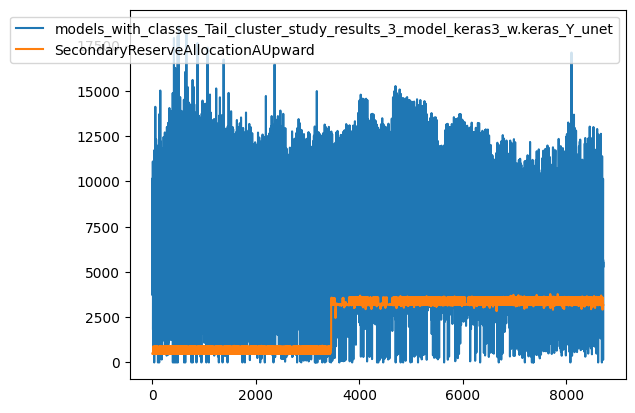

In [17]:
results_df[better_cols+[alloc_test_col]].dropna(axis=1).plot()